In [25]:
from math import sqrt, atan2, cos, sin
import numpy as np
from numpy import deg2rad, rad2deg

In [26]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)

In [27]:
from importlib import reload

## Initial state

In [28]:
import common
common = reload(common)
from common import Vector2

S1 = common.Ship()
S1.set_next_wp(Vector2(20, 20))

In [29]:
tilt = Vector2(0, 0)
pos = Vector2(0, 0)
direction = Vector2(0, 1)
next_wp = Vector2(20, 20)

speed = 5.0
maxspeed = 30.0

omega = 0

max_yaw_speed = max_pitch_speed = deg2rad(90)
angular_mobility = 2.0

In [30]:
theta0 = (next_wp - pos).angle_to(direction)
stheta0 = S1.get_theta()
theta0, stheta0

(0.7853981633974483, 0.7853981633974483)

In [31]:
def to_local(pos, target, direction):
    target_rel = target - pos
    angle = direction.angle_to(target_rel)
    return Vector2(0, 1).rotated(angle)

def to_global(pos, target_rel, direction):
    angle = Vector2(0, 1).angle_to(target_rel)
    return pos + direction.rotated(angle)

print(to_local(pos, next_wp, direction))
print(to_local(pos, next_wp, Vector2(1, 0)))
print(S1.to_local(S1.next_wp))

(0.7071067811865476, 0.7071067811865476)
(-0.7071067811865476, 0.7071067811865476)
(0.7071067811865476, 0.7071067811865476)


In [32]:
def d_theta(angle, ETA, omega, e, t):
    # z0 = angle / ETA - omega
    # s = np.sign(z0)
    # return z0 + s * e * t
    return angle / ETA - omega + e * t

def full_theta(angle, ETA, omega, e, t):
    k = angle + omega * ETA + e * ETA * ETA
    return angle - e * t * ETA + k * (np.exp(t / ETA) - 1)

def d_full_theta(angle, ETA, omega, e, t):
    k = angle + omega * ETA + e * ETA * ETA
    return -e * ETA + k / ETA * np.exp(t / ETA)

In [33]:
N = 1000
ETA = abs(next_wp - pos) / speed
print(ETA)

ts = np.linspace(0, 1, N)
thetas = full_theta(theta0, ETA, omega, max_yaw_speed, ts)
dt1 = np.array([d_theta(th, ETA, omega, max_yaw_speed, t) for t, th in zip(ts, thetas)])
dt2 = d_full_theta(theta0, ETA, omega, max_yaw_speed, ts)

5.656854249492381


In [34]:
a = d_theta(0.1, ETA, omega, max_yaw_speed, 1)
b = d_theta(0.2, ETA, omega, max_yaw_speed, 1)
print(a, b)

1.5884739963245602 1.6061516658542239


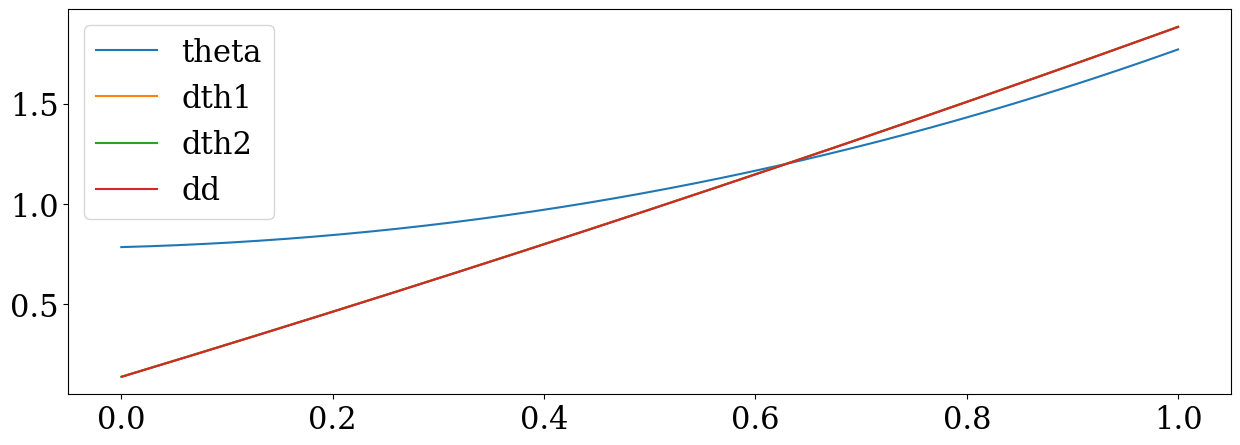

In [35]:
plt.plot(ts, thetas, label='theta')
plt.plot(ts, dt1, label='dth1')
plt.plot(ts, dt2, label='dth2')
plt.plot(ts[1:], np.diff(thetas) / np.diff(ts), label='dd')
plt.legend(loc='upper left')
plt.show()

## Simulation

In [36]:
def simulate_plain(pos, target, speed, direction, ts):
    coords = np.array([pos + direction * speed * t for t in ts])
    angles = np.array([(target - p).angle_to(direction) for p in coords])
    return angles, coords

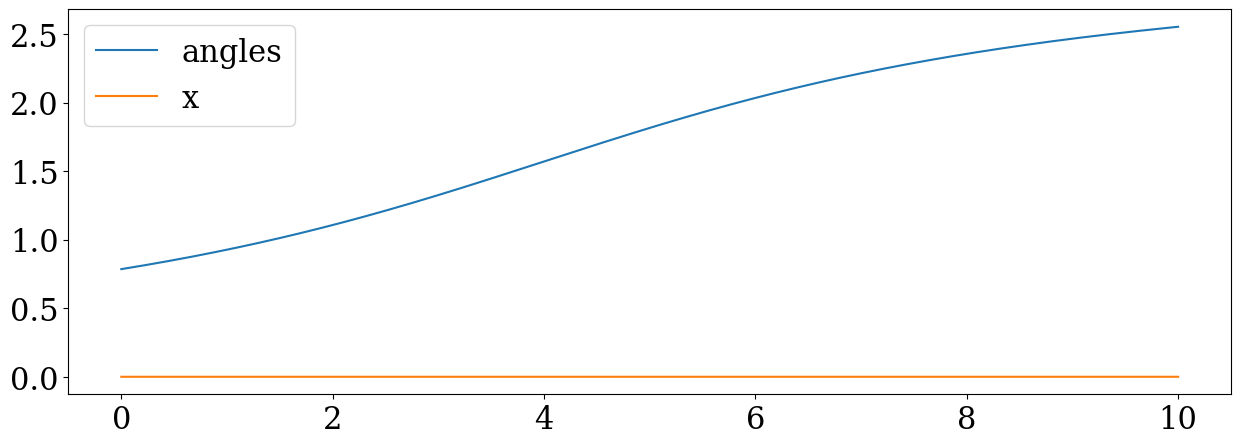

In [37]:
N = 10000
ts = np.linspace(0, 10, N)
ths, cs = simulate_plain(pos, next_wp, speed, direction, ts)
xs = np.array([x.x for x in cs])
zs = np.array([z.z for z in cs])

plt.plot(ts, ths, label='angles')
plt.plot(ts, xs, label='x')
# plt.plot(ts, zs, label='z')
plt.legend(loc='upper left')
plt.show()

In [38]:
from sym import sym

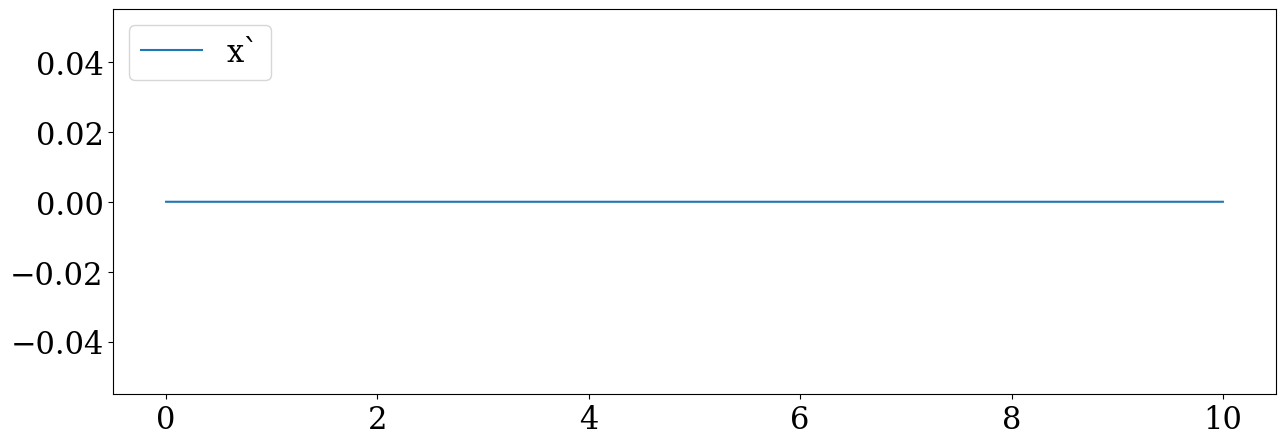

In [ ]:
scs, sths = sym(S1, ts)
sxs = np.array([x.x for x in scs])
szs = np.array([z.z for z in scs])

plt.plot(ts, sths, label='angles`')
plt.plot(ts, sxs, label='x`')
# plt.plot(ts, [x.z for x in sxs], label='z`')
plt.legend(loc='upper left')
plt.show()

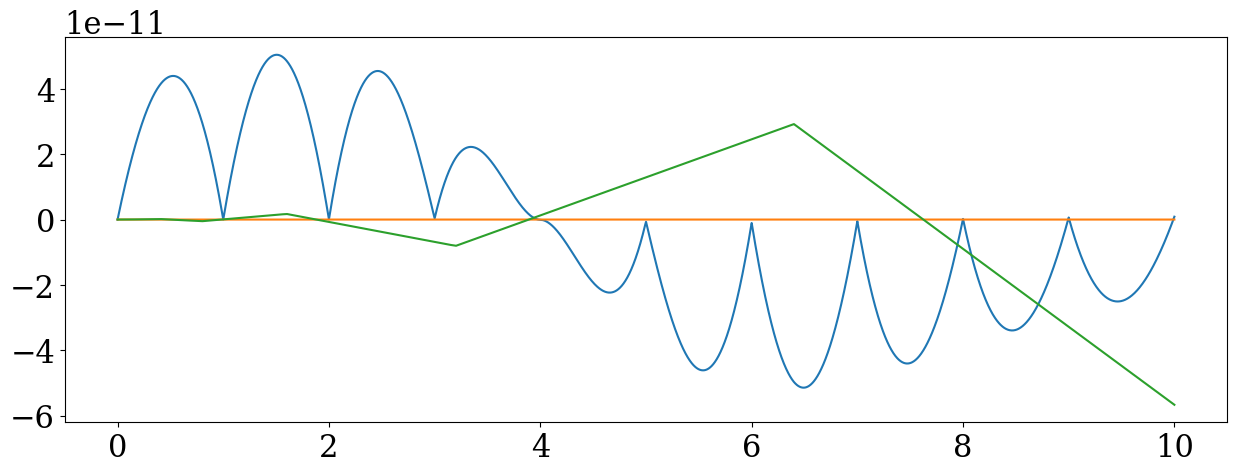

In [41]:
plt.plot(ts, sths - ths)
plt.plot(ts, xs - sxs)
plt.plot(ts, zs - szs)
plt.show()

In [98]:
def simulate_omega(pos, target, speed, direction, omega, ts):
    s = np.sign(omega)
    R = speed / omega
    center = pos - direction.rotated(np.pi / 2) * R
    rad = pos - center
    coords = np.array([center + rad.rotated(-t * omega) for t in ts])
    directions = np.array([direction.rotated(-t * omega) for t in ts])
    angles = np.array([(target - p).angle_to(d) for p, d in zip(coords, directions)])
    return angles, coords, directions

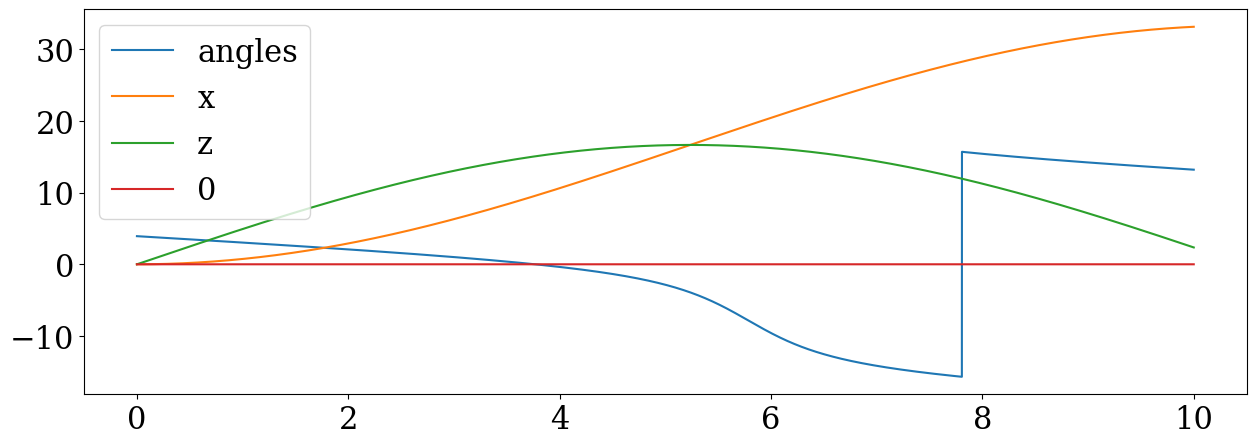

In [99]:
omega = 0.3
ths, xs, ds = simulate_omega(pos, next_wp, speed, direction, omega, ts)

plt.plot(ts, ths * 5, label='angles')
plt.plot(ts, [x.x for x in xs], label='x')
plt.plot(ts, [x.z for x in xs], label='z')
plt.plot(ts, ts * 0, label='0')
plt.legend(loc='upper left')
plt.show()

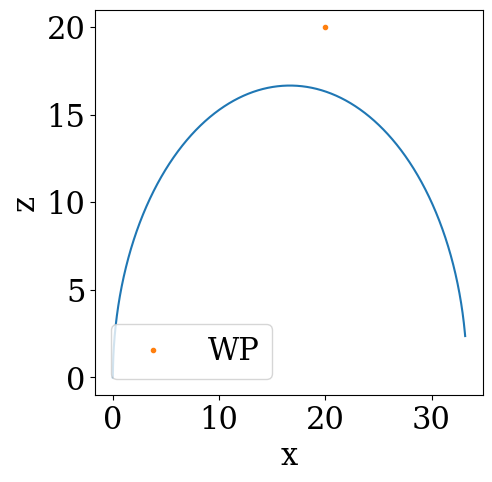

In [100]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs], [x.z for x in xs])
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower left')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

In [101]:
def simulate_omega_dt(pos, target, speed, direction, omega, T, dt=1e-3, decimate=1):
    t = 0
    p = pos
    d = direction
    coords = []
    directions = []
    di = 1
    while t < T:
        if di % decimate == 0:
            coords.append(p)
            directions.append(d)
        di += 1

        d = d.rotated(-dt * omega)
        p += d * speed * dt
        t += dt
    
    angles = np.array([(target - p).angle_to(d) for p, d in zip(coords, directions)])
    return angles, np.array(coords), np.array(directions)

In [102]:
omega = 0.2
dt = np.diff(ts)[0]
ths1, xs1, ds2 = simulate_omega(pos, next_wp, speed, direction, omega, ts)
ths2, xs2, ds2 = simulate_omega_dt(pos, next_wp, speed, direction, omega, ts[-1] + dt, dt / 10, decimate=10)
xs1.shape, xs2.shape

((10000,), (10000,))

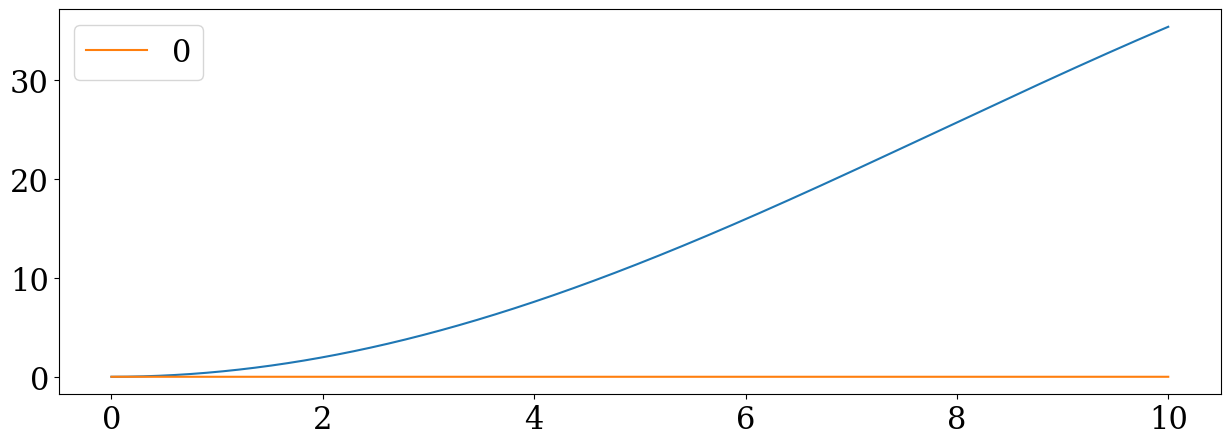

In [103]:
# plt.plot(ts, ths1 - ths2, label='angles diff')
# plt.plot(ts, [x.x for x in (xs1 - xs2)], label='x diff')
# plt.plot(ts, [x.z for x in (xs1 - xs2)], label='z diff')
plt.plot(ts, [x.x for x in xs2])
plt.plot(ts, ts * 0, label='0')
plt.legend(loc='upper left')
plt.show()

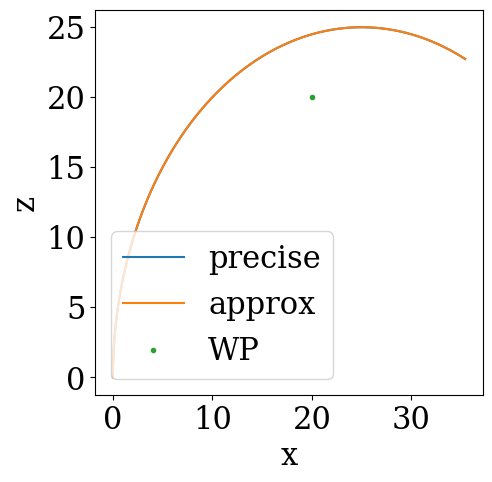

In [104]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs1], [x.z for x in xs1], label='precise')
plt.plot([x.x for x in xs2], [x.z for x in xs2], label='approx')
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower left')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

In [105]:
def simulate_omega_eps_dt(pos, target, speed, direction, omega, eps, T, dt=1e-3, decimate=1):
    t = 0
    p = pos
    w = omega
    d = direction
    coords = []
    directions = []
    di = 1
    while t < T:
        if di % decimate == 0:
            coords.append(p)
            directions.append(d)
        di += 1

        d = d.rotated(-dt * w)
        p += d * speed * dt
        w += eps * dt
        t += dt
    
    angles = np.array([(target - p).angle_to(d) for p, d in zip(coords, directions)])
    return angles, np.array(coords), np.array(directions)

In [106]:
omega0 = 0
eps = 0.1
t1 = 4.9
dt = 1e-2
ths1, xs1, ds1 = simulate_omega_eps_dt(pos, next_wp, speed, direction, omega0, eps, t1, dt, decimate=1)
pos2 = xs1[-1]
dir2 = ds1[-1]
t2 = 7.2 - t1
ths2, xs2, ds2 = simulate_omega_eps_dt(pos2, next_wp, speed, dir2, omega0 + eps * t1, -eps, t2, dt, decimate=1)

ths = np.concatenate([ths1, ths2])
xs = np.concatenate([xs1, xs2])
ds = np.concatenate([ds1, ds2])

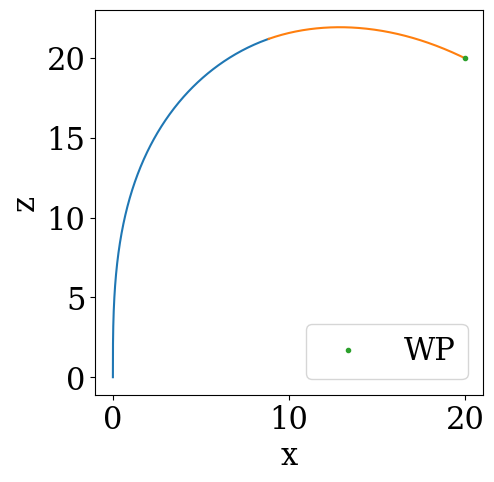

In [107]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs1], [x.z for x in xs1])
plt.plot([x.x for x in xs2], [x.z for x in xs2])
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower right')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

## Analytical solution

In [108]:
ts = np.arange(0, dt * xs.shape[0], dt)
ts1 = ts[:xs1.shape[0]]
ts2 = ts[:xs2.shape[0]]

In [109]:
from scipy.special import fresnel

In [110]:
def line(pos, direction, speed, t):
    if isinstance(t, (float, int)):
        return pos + direction.normalized() * t, direction
    elif isinstance(t, (np.ndarray, list)):
        return np.array([pos + direction.normalized() * t_ for t_ in t]), np.array([direction] * len(t))

def circle(pos, direction, speed, omega, t):
    if omega == 0:
        return line(pos, direction, speed, t)
    center = pos + Vector2(-direction.z, direction.x) * speed / omega
    rad = pos - center
    if isinstance(t, (float, int)):
        return center + rad.rotated(omega * t), direction.rotated(omega * t)
    elif isinstance(t, (np.ndarray, list)):
        return np.array([center + rad.rotated(omega * t_) for t_ in t]), np.array([direction.rotated(omega * t_) for t_ in t])

def fresnel_curve(speed, eps, t):
    S, C = fresnel(t * np.sqrt(abs(eps)) / np.sqrt(np.pi))

    lin = speed * np.sqrt(np.pi) / np.sqrt(abs(eps))
    if isinstance(t, (float, int)):
        return Vector2(lin * S * sign(eps), lin * C)
    elif isinstance(t, (np.ndarray, list)):
        return [Vector2(lin * s * sign(eps), lin * c) for s, c in zip(S, C)]

def fresnel_direction(eps, t):
    if isinstance(t, (float, int)):
        return Vector2(np.sin(t ** 2 * eps / 2), np.cos(t ** 2 * eps / 2))
    elif isinstance(t, (np.ndarray, list)):
        return [fresnel_direction(eps, t_) for t_ in t]

def global_trajectory(pos, direction, speed, omega, eps, t):
    if eps == 0:
        return circle(pos, direction, speed, omega, t)
    
    t1 = omega / eps
    t2 = t1 + t
    
    if isinstance(t, (float, int)):
        t2 = np.array([t2])
    
    p_start = fresnel_curve(speed, eps, t1)
    p_finish = fresnel_curve(speed, eps, t2)
    angle = -Vector2(0, 1).angle_to(fresnel_direction(eps, t1))
    angle_base = -direction.angle_to(Vector2(0, 1))
    p_local = [pf - p_start for pf in p_finish]
    global_coords = np.array([p.rotated(angle_base + angle) + pos for p in p_local])
    global_dirs = np.array([d.rotated(angle_base + angle) for d in fresnel_direction(eps, t2)])

    if isinstance(t, (float, int)):
        global_coords = global_coords[0]
        global_dirs = global_dirs[0]
    return global_coords, global_dirs

def global_theta(pos, direction, speed, omega, t):
    if eps == 0:
        return circle(pos, direction, speed, omega, t)[1]
    
    t1 = omega / eps
    t2 = t1 + t
    
    if isinstance(t, (float, int)):
        t2 = np.array([t2])
    
    angle = -Vector2(0, 1).angle_to(fresnel_direction(eps, t1))
    angle_base = -direction.angle_to(Vector2(0, 1))
    global_dirs = np.array([d.rotated(angle_base + angle) for d in fresnel_direction(eps, t2)])

    if isinstance(t, (float, int)):
        global_dirs = global_dirs[0]
    return global_dirs


In [111]:
xs_eq, ds_eq = global_trajectory(pos, direction, speed, omega0, eps, ts1)
xs2_eq, ds2_eq = global_trajectory(xs_eq[-1], ds_eq[-1], speed, eps * t1, -eps, ts2 - ts2[0])

x1, d1 = global_trajectory(xs_eq[0], ds_eq[0], speed, 0, 0, np.linspace(0, 5, 10))
x2, d2 = global_trajectory(xs_eq[-1], ds_eq[-1], speed, 0, 0, np.linspace(0, 5, 10))
x3, d3 = global_trajectory(xs2_eq[0], ds2_eq[0], speed, 0, 0, np.linspace(0, 5, 10))
x4, d4 = global_trajectory(xs2_eq[-1], ds2_eq[-1], speed, 0, 0, np.linspace(0, 5, 10))

ds_eq[-1], ds2_eq[0]

((0.9322201483320324, 0.36189168965838875),
 (0.9322201483320324, 0.3618916896583888))

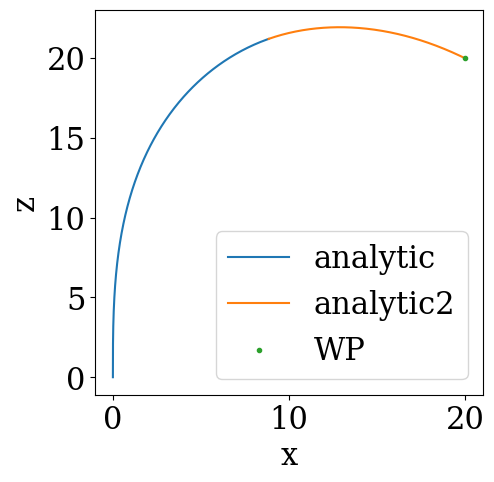

In [112]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in xs_eq], [x.z for x in xs_eq], label='analytic')
plt.plot([x.x for x in xs2_eq], [x.z for x in xs2_eq], label='analytic2')

# plt.plot([x.x for x in xs1], [x.z for x in xs1], label='sim')
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower right')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

## Strategy research

In [113]:
def get_theta(pos, target, direction):
    if isinstance(pos, (list, np.ndarray)):
        if not isinstance(direction, (list, np.ndarray)):
            direction = [direction] * len(pos)
        return np.array([get_theta(p, target, d) for p, d in zip(pos, direction)])
    return (target - pos).angle_to(direction)

In [114]:
strategy = np.concatenate([np.zeros_like(xs1), np.ones_like(xs2)])
ts = np.arange(0, dt * xs.shape[0], dt)
ts1 = ts[:xs1.shape[0]]
ts2 = ts[:xs2.shape[0]]

ws = omega0 + np.concatenate([[eps * t for t in ts1], [eps * (xs1.shape[0] * dt - t) for t in ts2]])
target_theta = ths - ths[0]

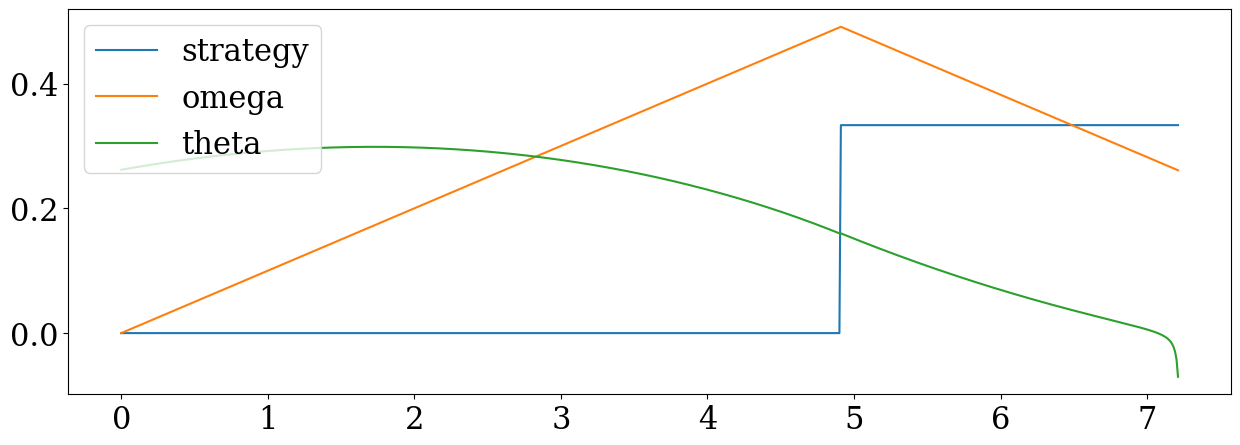

In [115]:
plt.plot(ts, strategy / 3, label='strategy')
plt.plot(ts, ws, label='omega')
plt.plot(ts, ths / 3, label='theta')
plt.legend(loc='upper left')
plt.show()

In [116]:
def estimate_tau(omega, eps):
    return omega / eps

def estimate_theta_when_tau(pos, target, direction, speed, omega, eps):
    # point 1: current point
    # point 2: omega' = 0, linear movement
    tau = estimate_tau(omega, eps) # time from point 1 to 2
    seps = -sign(omega) * abs(eps)
    pos_tau, dir_tau = global_trajectory(pos, direction, speed, omega, seps, tau)
    return get_theta(pos_tau, target, dir_tau), tau, pos_tau, dir_tau

In [117]:
th_tau, tau, ptau, dtau = estimate_theta_when_tau(xs_eq[-1], next_wp, ds_eq[-1], speed, eps * t1, eps)
thi = np.argmax(ts > tau)
th_tau, ths[thi], ptau, dtau

(3.0316844295755696,
 0.47959423077970115,
 (29.66658833356595, 11.51669141419384),
 (0.674725449226946, -0.7380688099123929))

## Simulating example

In [118]:
T1 = 1.7
T2 = 2.8
T3 = T1

eps2 = 2 * eps

t_seg1 = np.linspace(0, T1, int(N * T1))
t_seg2 = np.linspace(0, T2, int(N * T2))
t_seg3 = np.linspace(0, T3, int(N * T3))

tx1, td1 = global_trajectory(pos, direction, speed, omega0, eps2, t_seg1)
tx2, td2 = circle(tx1[-1], td1[-1], speed, -(omega0 + eps2 * T1), t_seg2)
tx3, td3 = global_trajectory(tx2[-1], td2[-1], speed, omega0 + eps2 * T1, -eps2, t_seg3)

tx = np.concatenate([tx1, tx2, tx3])
td = np.concatenate([td1, td2, td3])
tsf = np.concatenate([t_seg1, t_seg2 + T1, t_seg3 + T1 + T2])

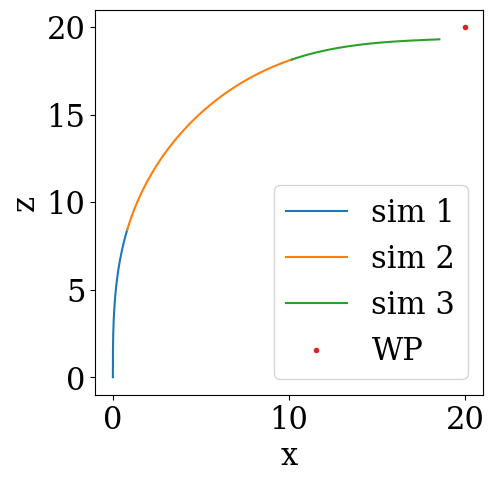

In [119]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([x.x for x in tx1], [x.z for x in tx1], label='sim 1')
plt.plot([x.x for x in tx2], [x.z for x in tx2], label='sim 2')
plt.plot([x.x for x in tx3], [x.z for x in tx3], label='sim 3')
plt.plot(next_wp.x, next_wp.z, '.', label='WP')
plt.legend(loc='lower right')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

## Predicting theta along sim 2

In [120]:
ths_predict = []
taus = []
for x, d, t in zip(tx2, td2, t_seg2):
    th, tau, _, _ = estimate_theta_when_tau(x, next_wp, d, speed, omega0 + eps2 * T1, eps2)
    ths_predict.append(th)
    taus.append(tau)
ths_predict = np.array(ths_predict)
taus = np.array(taus)

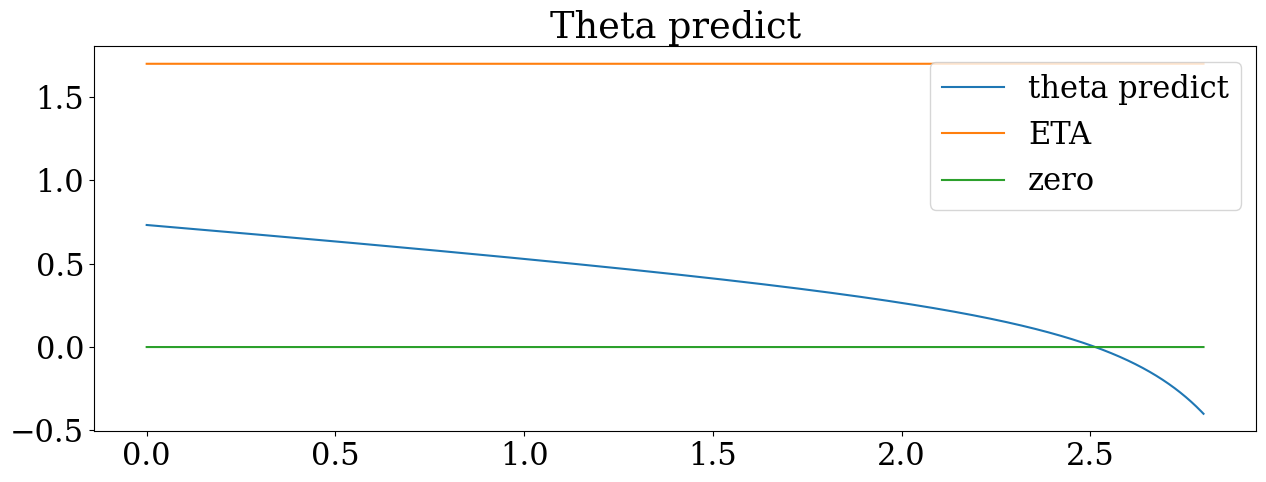

In [121]:
plt.title("Theta predict")
plt.plot(t_seg2, ths_predict, label='theta predict')
plt.plot(t_seg2, taus, label='ETA')
plt.plot(t_seg2, np.zeros_like(t_seg2), label='zero')
plt.legend(loc='upper right')
plt.show()

## Predicting with Fresnel approximation

In [222]:
from math import factorial
APP_PRECISION = 4
def fresnel_approx(x: float) -> tuple[float, float]:
    X = x * np.sqrt(np.pi / 2)
    S = 0
    C = 0
    for i in range(APP_PRECISION):
        S += (-1) ** i * X ** (4 * i + 3) / (4 * i + 3) / factorial(2 * i + 1)
        C += (-1) ** i * X ** (4 * i + 1) / (4 * i + 1) / factorial(2 * i)
    return S * np.sqrt(2 / np.pi), C * np.sqrt(2 / np.pi)

def fresnel_curve_approx(speed, eps, t):
    S, C = fresnel_approx(t * np.sqrt(abs(eps)) / np.sqrt(np.pi))

    lin = speed * np.sqrt(np.pi) / np.sqrt(abs(eps))
    if isinstance(t, (float, int)):
        return Vector2(lin * S * sign(eps), lin * C)
    elif isinstance(t, (np.ndarray, list)):
        return [Vector2(lin * s * sign(eps), lin * c) for s, c in zip(S, C)]

def global_trajectory_approx(pos, direction, speed, omega, eps, t):
    if eps == 0:
        return circle(pos, direction, speed, omega, t)
    
    t1 = omega / eps
    t2 = t1 + t
    
    if isinstance(t, (float, int)):
        t2 = np.array([t2])
    
    p_start = fresnel_curve_approx(speed, eps, t1)
    p_finish = fresnel_curve_approx(speed, eps, t2)
    angle = -Vector2(0, 1).angle_to(fresnel_direction(eps, t1))
    angle_base = -direction.angle_to(Vector2(0, 1))
    p_local = [pf - p_start for pf in p_finish]
    global_coords = np.array([p.rotated(angle_base + angle) + pos for p in p_local])
    global_dirs = np.array([d.rotated(angle_base + angle) for d in fresnel_direction(eps, t2)])

    if isinstance(t, (float, int)):
        global_coords = global_coords[0]
        global_dirs = global_dirs[0]
    return global_coords, global_dirs

def estimate_theta_when_tau_approx(pos, target, direction, speed, omega, eps):
    # point 1: current point
    # point 2: omega' = 0, linear movement
    tau = estimate_tau(omega, eps) # time from point 1 to 2
    seps = -sign(omega) * abs(eps)
    pos_tau, dir_tau = global_trajectory_approx(pos, direction, speed, omega, seps, tau)
    return get_theta(pos_tau, target, dir_tau), tau, pos_tau, dir_tau

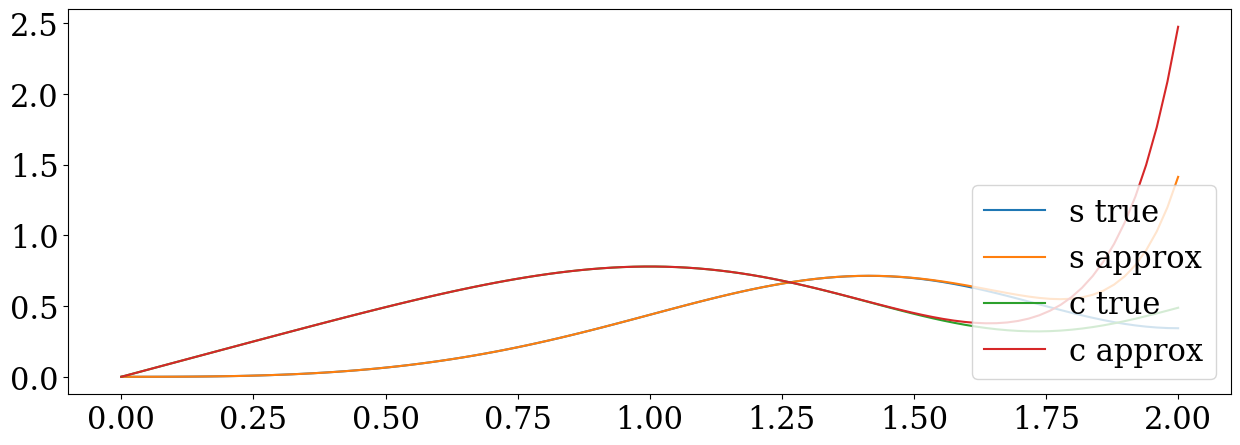

In [223]:
axs = np.linspace(0, 2, 100)
s1, c1 = fresnel(axs)
s2, c2 = fresnel_approx(axs)
plt.plot(axs, s1, label='s true')
plt.plot(axs, s2, label='s approx')
plt.plot(axs, c1, label='c true')
plt.plot(axs, c2, label='c approx')
plt.legend(loc='lower right')
plt.show()

In [224]:
ths_predict_app = []
taus_app = []
for x, d, t in zip(tx2, td2, t_seg2):
    th, tau, _, _ = estimate_theta_when_tau_approx(x, next_wp, d, speed, omega0 + eps2 * T1, eps2)
    ths_predict_app.append(th)
    taus_app.append(tau)
ths_predict_app = np.array(ths_predict_app)
taus_app = np.array(taus_app)

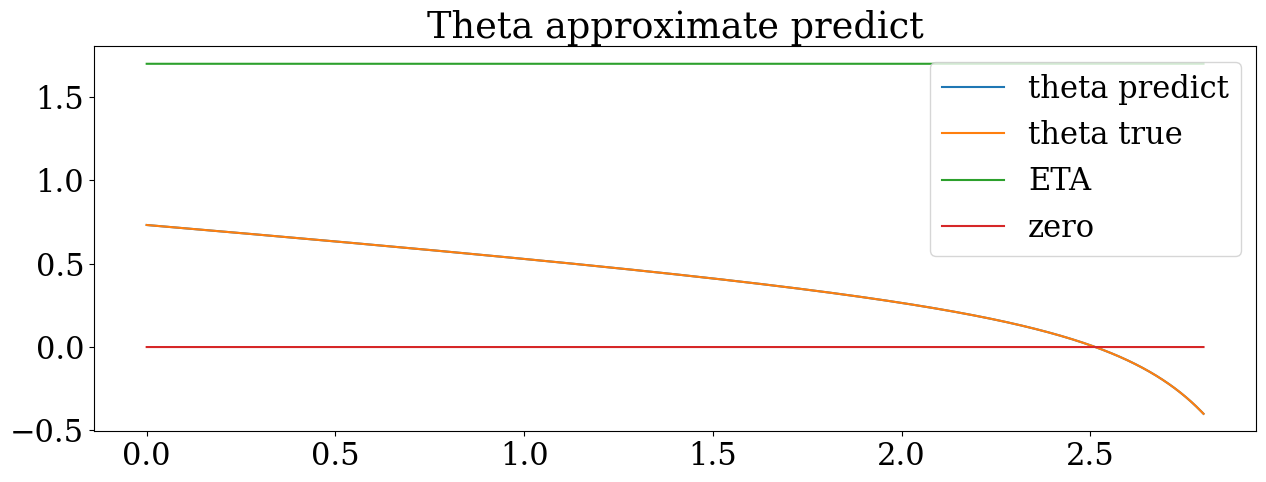

In [225]:
plt.title("Theta approximate predict")
plt.plot(t_seg2, ths_predict_app, label='theta predict')
plt.plot(t_seg2, ths_predict, label='theta true')
plt.plot(t_seg2, taus_app, label='ETA')
plt.plot(t_seg2, np.zeros_like(t_seg2), label='zero')
plt.legend(loc='upper right')
plt.show()

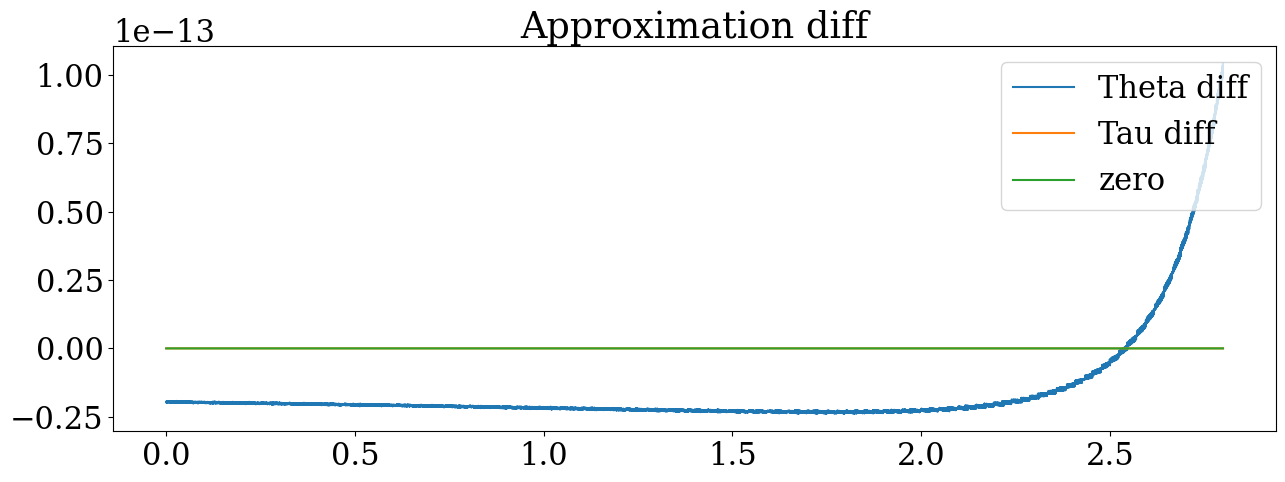

In [226]:
plt.title("Approximation diff")
plt.plot(t_seg2, ths_predict - ths_predict_app, label='Theta diff')
plt.plot(t_seg2, taus - taus_app, label='Tau diff')
plt.plot(t_seg2, np.zeros_like(t_seg2), label='zero')
plt.legend(loc='upper right')
plt.show()